In [1]:
MODEL_DIR = '../input/commonlit-readability-prize-dataset/models'
BERT_BASE_UNCASED_PRETRAINED_DIR = '../input/bert-base-uncased'
ROBERTA_BASE_PRETRAINED_DIR = '../input/roberta-base'
ROBERTA_LARGE_PRETRAINED_DIR = '../input/robertalarge'
DISTILBERT_BASE_UNCASED_PRETRAINED_DIR = '../input/distilbertbaseuncased'
BART_BASE_PRETRAINED_DIR = '../input/bartbase'

In [2]:
!pip install ../input/commonlit-readability-prize-dataset/packages/readability
!pip install ../input/commonlit-readability-prize-dataset/packages/Pyphen-0.10.0-py3-none-any.whl
!pip install ../input/commonlit-readability-prize-dataset/packages/textstat-0.7.0-py3-none-any.whl

Processing /kaggle/input/commonlit-readability-prize-dataset/packages/readability
  Created wheel for readability: filename=readability-0.3.1-py3-none-any.whl size=35613 sha256=050c6a09c2c3fe8399bb08e47e37154b962cf6ae4a8104e47548a03962038fee
  Stored in directory: /tmp/pip-ephem-wheel-cache-3qh45fz6/wheels/9e/60/a8/380534ab3129e6da8c5bea1ea72edeac24f79522456a44b44f
Successfully built readability
Processing /kaggle/input/commonlit-readability-prize-dataset/packages/Pyphen-0.10.0-py3-none-any.whl
Processing /kaggle/input/commonlit-readability-prize-dataset/packages/textstat-0.7.0-py3-none-any.whl


In [3]:
import os
import random
import pickle
import tqdm
import gc

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import tensorflow_hub as hub

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SequentialSampler

from transformers import (
    BertModel, BertTokenizer, BertConfig,
    RobertaModel, RobertaTokenizer, RobertaConfig,
    DistilBertModel, DistilBertTokenizer, DistilBertConfig,
    BartModel, BartTokenizer, BartConfig
)
import spacy
import textstat
import readability
from nltk.tokenize import word_tokenize

In [4]:
TF_MEMORY_USAGE = 4
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * TF_MEMORY_USAGE)]
        )
    except RuntimeError as e:
        print(e)
    
print(f'TensorFlow GPU memory usage restricted to {TF_MEMORY_USAGE} gigabytes.')

TensorFlow GPU memory usage restricted to 4 gigabytes.


In [5]:
df_train = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
df_test = pd.read_csv('../input/commonlitreadabilityprize/test.csv')

print(f'Training Set Shape: {df_train.shape}')
print(f'Training Set Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Test Set Shape: {df_test.shape}')
print(f'Test Set Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Training Set Shape: (2834, 6)
Training Set Memory Usage: 0.13 MB
Test Set Shape: (7, 4)
Test Set Memory Usage: 0.00 MB


## Preprocessing

In [6]:
class Preprocessor:
    
    def __init__(self, train, test, n_splits, shuffle, random_state):
        
        self.train = train.copy(deep=True)
        self.test = test.copy(deep=True)
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state
        
    def set_seed(self, seed):
        
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)
    
    def get_folds(self):
        
        self.set_seed(self.random_state)
        
        n_bins = np.int(np.floor(1 + np.log2(len(self.train))))
        self.train['bins'] = pd.cut(self.train['target'], n_bins).astype(str)
        skf = StratifiedKFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        
        for fold, (_, val_idx) in enumerate(skf.split(self.train, self.train['bins'].factorize()[0]), 1):
            self.train.loc[val_idx, 'fold'] = fold

        self.train['fold'] = self.train['fold'].astype(np.uint8)
        self.train.drop(columns=['bins'], inplace=True)
                
    def extract_count_features(self):
        
        vectorizer = CountVectorizer(
            lowercase=True,
            ngram_range=(1, 2)
        )
        
        train_features = vectorizer.fit_transform(self.train['excerpt'].values)
        test_features = vectorizer.transform(self.test['excerpt'].values)
        
        return train_features, test_features
    
    def extract_tfidf_features(self):
        
        vectorizer = TfidfVectorizer(
            lowercase=True,
            ngram_range=(1, 2),
            max_features=50000,
        )
        
        train_features = vectorizer.fit_transform(self.train['excerpt'].values)
        test_features = vectorizer.transform(self.test['excerpt'].values)
        
        return train_features, test_features
    
    def extract_eng_pipeline_features(self):
        
        nlp = spacy.load('en_core_web_lg')
        with nlp.disable_pipes():
            train_features = np.array([nlp(text).vector for text in tqdm.tqdm(self.train['excerpt'])])
            test_features = np.array([nlp(text).vector for text in tqdm.tqdm(self.test['excerpt'])])
            
        return train_features, test_features
    
    def extract_use_features(self):
    
        self.set_seed(self.random_state)
        universal_sentence_encoder = hub.load(f'{MODEL_DIR}/universal-sentence-encoder-large_5')

        train_tokenized = self.train['excerpt'].apply(lambda x: [' '.join(word_tokenize(str(x).lower()))])
        train_use_features = np.array([universal_sentence_encoder(text).numpy() for text in tqdm.tqdm(train_tokenized)]).reshape(-1, 512)

        test_tokenized = self.test['excerpt'].apply(lambda x: [' '.join(word_tokenize(str(x).lower()))])
        test_use_features = np.array([universal_sentence_encoder(text).numpy() for text in tqdm.tqdm(test_tokenized)]).reshape(-1, 512)

        return train_use_features, test_use_features
        
    def extract_readability_features(self):
        
        for df in [self.train, self.test]:
            df['mean_word_length'] = df['excerpt'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
            df['syllable_count'] = df['excerpt'].apply(textstat.syllable_count)
            df['sentence_count'] = df['excerpt'].apply(textstat.sentence_count)
            df['flesch_reading_ease'] = df['excerpt'].apply(textstat.flesch_reading_ease)
            df['flesch_kincaid_grade'] = df['excerpt'].apply(textstat.flesch_kincaid_grade)
            df['smog_index'] = df['excerpt'].apply(textstat.smog_index)
            df['automated_readability_index'] = df['excerpt'].apply(textstat.automated_readability_index)
            df['coleman_liau_index'] = df['excerpt'].apply(textstat.coleman_liau_index)
            df['linsear_write_formula'] = df['excerpt'].apply(textstat.linsear_write_formula)
            df['gunning_fog_index'] = df['excerpt'].apply(lambda x: readability.getmeasures(x)['readability grades']['GunningFogIndex'])
            df['lix'] = df['excerpt'].apply(lambda x: readability.getmeasures(x)['readability grades']['LIX'])
            df['rix'] = df['excerpt'].apply(lambda x: readability.getmeasures(x)['readability grades']['RIX'])
            df['dale_chall_index'] = df['excerpt'].apply(lambda x: readability.getmeasures(x)['readability grades']['DaleChallIndex'])
            df['word_types'] = df['excerpt'].apply(lambda x: readability.getmeasures(x)['sentence info']['wordtypes'])
            df['to_be_verb'] = df['excerpt'].apply(lambda x: readability.getmeasures(x)['word usage']['tobeverb'])
            df['aux_verb'] = df['excerpt'].apply(lambda x: readability.getmeasures(x)['word usage']['auxverb'])
            df['nominalization'] = df['excerpt'].apply(lambda x: readability.getmeasures(x)['word usage']['nominalization'])
            df['sentence_beginning_conjunction'] = df['excerpt'].apply(lambda x: readability.getmeasures(x)['sentence beginnings']['conjunction'])
            
        readability_features = [
            'mean_word_length',
            'syllable_count',
            'sentence_count',
            'flesch_reading_ease',
            'flesch_kincaid_grade',
            'smog_index',
            'automated_readability_index',
            'coleman_liau_index',
            'linsear_write_formula',
            'gunning_fog_index',
            'lix',
            'rix',
            'dale_chall_index',
            'word_types',
            'to_be_verb',
            'aux_verb',
            'nominalization',
            'sentence_beginning_conjunction',
        ]

        scaler = StandardScaler()
        self.train[readability_features] = scaler.fit_transform(self.train[readability_features])
        self.test[readability_features] = scaler.transform(self.test[readability_features])
        
        for readability_feature in readability_features:
            self.train[readability_feature] = self.train[readability_feature].astype(np.float32)
            self.test[readability_feature] = self.test[readability_feature].astype(np.float32)
   
    def transform(self):
        
        self.get_folds()
        self.extract_readability_features()
        
        return self.train.copy(deep=True), self.test.copy(deep=True)


In [7]:
preprocessor_parameters = {
    'train': df_train,
    'test': df_test,
    'n_splits': 5,
    'shuffle': True,
    'random_state': 42
}

preprocessor = Preprocessor(**preprocessor_parameters)
df_train, df_test = preprocessor.transform()

readability_features = [
    'mean_word_length',
    'syllable_count',
    'sentence_count',
    'flesch_reading_ease',
    'flesch_kincaid_grade',
    'smog_index',
    'automated_readability_index',
    'coleman_liau_index',
    'linsear_write_formula',
    'gunning_fog_index',
    'lix',
    'rix',
    'dale_chall_index',
    'word_types',
    'to_be_verb',
    'aux_verb',
    'nominalization',
    'sentence_beginning_conjunction',
]

print(f'Processed Training Set Shape: {df_train.shape}')
print(f'Processed Training Set Memory Usage: {df_train.memory_usage().sum() / 1024 ** 2:.2f} MB')
print(f'Processed Test Set Shape: {df_test.shape}')
print(f'Processed Test Set Memory Usage: {df_test.memory_usage().sum() / 1024 ** 2:.2f} MB')

Processed Training Set Shape: (2834, 25)
Processed Training Set Memory Usage: 0.33 MB
Processed Test Set Shape: (7, 22)
Processed Test Set Memory Usage: 0.00 MB


In [8]:
train_use_features, test_use_features = preprocessor.extract_use_features()

print(f'Training Set Universal Sentence Encoder Features Shape: {train_use_features.shape}')
print(f'Test Set Universal Sentence Encoder Features Shape: {test_use_features.shape}')

100%|██████████| 7/7 [00:00<00:00, 34.93it/s]


Training Set Universal Sentence Encoder Features Shape: (2834, 512)
Test Set Universal Sentence Encoder Features Shape: (7, 512)


In [9]:
del preprocessor, preprocessor_parameters
gc.collect()

268075

## Visualizations

In [10]:
def draw_predictions(y_true, y_pred):
        
    fig, axes = plt.subplots(ncols=2, figsize=(32, 6))

    sns.scatterplot(x=y_true, y=y_pred, ax=axes[0])
    sns.kdeplot(y_true, label='Target', fill=True, ax=axes[1])
    sns.kdeplot(y_pred, label='Predictions', fill=True, ax=axes[1])

    axes[0].set_xlabel(f'Target', size=18)
    axes[0].set_ylabel(f'Predictions', size=18)
    axes[1].set_xlabel('')
    axes[1].legend(prop={'size': 15})
    for i in range(2):
        axes[i].tick_params(axis='x', labelsize=15)
        axes[i].tick_params(axis='y', labelsize=15)
    axes[0].set_title(f'Target vs Predictions', size=20, pad=20)
    axes[1].set_title(f'Target and Predictions Distributions', size=20, pad=20)

    plt.show()

## Linear Model

In [11]:
class LinearModel:
    
    def __init__(self, model_name, model_parameters):
        
        self.model_name = model_name
        self.model_parameters = model_parameters
        
    def train_and_predict_ridge(self, X_train, y_train, X_test):
        
        print(f'{"-" * 30}\nRunning Ridge Regression Model\n{"-" * 30}')
        df_train[f'{self.model_name}_predictions'] = 0
        df_test[f'{self.model_name}_predictions'] = 0
        
        for fold in sorted(df_train['fold'].unique()):

            trn_idx, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index
            X_trn, y_trn = X_train[trn_idx], df_train.loc[trn_idx, 'target']
            X_val, y_val = X_train[val_idx], df_train.loc[val_idx, 'target']

            model = Ridge(**self.model_parameters)
            model.fit(X_trn, y_trn)

            predictions = model.predict(X_val)
            df_train.loc[val_idx, f'{self.model_name}_predictions'] = predictions
            fold_score = mean_squared_error(df_train.loc[val_idx, 'target'], df_train.loc[val_idx, f'{self.model_name}_predictions'], squared=False)
            df_test[f'{self.model_name}_predictions'] += (model.predict(X_test) / df_train['fold'].nunique())

            print(f'Fold {fold} - X_trn Shape: {X_trn.shape} - X_val Shape: {X_val.shape} - RMSE: {fold_score:.6}')
            
            del model, predictions
            del trn_idx, val_idx, X_trn, y_trn, X_val, y_val

        oof_score = mean_squared_error(df_train['target'], df_train[f'{self.model_name}_predictions'], squared=False)
        print(f'{"-" * 50}\nRidge Regression - OOF RMSE: {oof_score:.6}\n{"-" * 50}')
        draw_predictions(df_train['target'], df_train[f'{self.model_name}_predictions'])
        
    def train_and_predict_svm(self, X_train, y_train, X_test):
        
        print(f'{"-" * 17}\nRunning SVM Model\n{"-" * 17}')
        df_train[f'{self.model_name}_predictions'] = 0
        df_test[f'{self.model_name}_predictions'] = 0
        
        for fold in sorted(df_train['fold'].unique()):

            trn_idx, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index
            X_trn, y_trn = X_train[trn_idx], df_train.loc[trn_idx, 'target']
            X_val, y_val = X_train[val_idx], df_train.loc[val_idx, 'target']

            model = SVR(**self.model_parameters)
            model.fit(X_trn, y_trn)

            predictions = model.predict(X_val)
            df_train.loc[val_idx, f'{self.model_name}_predictions'] = predictions
            fold_score = mean_squared_error(df_train.loc[val_idx, 'target'], df_train.loc[val_idx, f'{self.model_name}_predictions'], squared=False)
            df_test[f'{self.model_name}_predictions'] += (model.predict(X_test) / df_train['fold'].nunique())

            print(f'Fold {fold} - X_trn Shape: {X_trn.shape} - X_val Shape: {X_val.shape} - RMSE: {fold_score:.6}')
            
            del model, predictions
            del trn_idx, val_idx, X_trn, y_trn, X_val, y_val

        oof_score = mean_squared_error(df_train['target'], df_train[f'{self.model_name}_predictions'], squared=False)
        print(f'{"-" * 50}\nSVM - OOF RMSE: {oof_score:.6}\n{"-" * 50}')
        draw_predictions(df_train['target'], df_train[f'{self.model_name}_predictions'])


## Dataset

In [12]:
class ExcerptDataset(Dataset):
    
    def __init__(self, excerpts, labels, tokenizer, max_seq_len):
        
        self.excerpts = excerpts.values.tolist()
        if labels is not None:
            self.labels = labels.values.tolist()
        else:
            self.labels = None
        
        self.tokenizer = tokenizer
        self.max_seq_len = max_seq_len
    
    def __len__(self):
        return len(self.excerpts)
    
    def _encode(self, text, max_seq_len):
    
        text = text.replace('\n', '')
        tokenized = self.tokenizer.encode_plus(
            text, 
            max_length=max_seq_len, 
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True
        )

        sequence = {}
        pad_len = max_seq_len - len(tokenized['input_ids'])
        sequence['input_ids'] = tokenized['input_ids'] + ([0] * pad_len)
        sequence['token_type_ids'] = tokenized['token_type_ids'] + ([0] * pad_len)
        sequence['attention_mask'] = tokenized['attention_mask'] + ([0] * pad_len)
        return sequence

    def __getitem__(self, idx):
        
        if self.labels is not None:
            excerpt, label = self.excerpts[idx], self.labels[idx]
            tokenized = self._encode(excerpt, self.max_seq_len)
            
            return {
                'input_ids': torch.tensor(tokenized['input_ids'], dtype=torch.long),
                'token_type_ids': torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
                'attention_mask': torch.tensor(tokenized['attention_mask'], dtype=torch.long),
                'label': torch.tensor(label, dtype=torch.float),
            }
        else:
            excerpt = self.excerpts[idx]
            tokenized = self._encode(excerpt, self.max_seq_len)
            
            return {
                'input_ids': torch.tensor(tokenized['input_ids'], dtype=torch.long),
                'token_type_ids': torch.tensor(tokenized['token_type_ids'], dtype=torch.long),
                'attention_mask': torch.tensor(tokenized['attention_mask'], dtype=torch.long),
            }


## BERT

In [13]:
class BERTModel(nn.Module):
    
    def __init__(self, pretrained_model_path, output_hidden_states=False):
        
        super(BERTModel, self).__init__()
        self.bert = BertModel.from_pretrained(pretrained_model_path, output_hidden_states=output_hidden_states)
        self.config = BertConfig.from_pretrained(pretrained_model_path)
        self.config.update({'num_labels': 1})
        
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(0.25)
        self.head = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.layer_norm)
        self._init_weights(self.head)
 
    def _init_weights(self, module):
        
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
 
    def forward(self, input_ids, attention_mask, token_type_ids):
        
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[1]
        sequence_output = self.layer_norm(sequence_output)
        output = self.head(self.dropout(sequence_output))
        output = output.view(-1)
        return output


In [14]:
class BERTPipeline:
    
    def __init__(self, model_name, model_parameters, pretrained_model_path, max_seq_len, random_state):
        
        self.model_name = model_name
        self.model_parameters = model_parameters
        self.pretrained_model_path = pretrained_model_path
        self.max_seq_len = max_seq_len
        self.random_state = random_state
        
    def set_seed(self, seed):

        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
                
    def get_model(self):
        
        model = BERTModel(pretrained_model_path=self.pretrained_model_path)
        return model
    
    def inference(self, X_train, y_train, X_test):
        
        print(f'\n{"-" * 40}\nRunning PyTorch BERT Model for Inference\n{"-" * 40}')
        df_train[f'{self.model_name}_predictions'] = 0
        df_test[f'{self.model_name}_predictions'] = 0
        
        test_dataset = ExcerptDataset(
            excerpts=X_test,
            labels=None,
            tokenizer= BertTokenizer.from_pretrained(self.pretrained_model_path),
            max_seq_len=self.max_seq_len
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=self.model_parameters['batch_size'], 
            sampler=SequentialSampler(test_dataset), 
            pin_memory=False, 
            drop_last=False, 
            num_workers=0
        )
        
        for fold in sorted(df_train['fold'].unique()):
            
            _, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index
            val_dataset = ExcerptDataset(
                excerpts=X_train.loc[val_idx],
                labels=y_train.loc[val_idx],
                tokenizer=BertTokenizer.from_pretrained(self.pretrained_model_path),
                max_seq_len=self.max_seq_len
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.model_parameters['batch_size'],
                sampler=SequentialSampler(val_dataset),
                pin_memory=False,
                drop_last=False,
                num_workers=0
            )
            
            self.set_seed(self.random_state)
            model = self.get_model()
            model.load_state_dict(torch.load(f'../input/commonlit-readability-prize-dataset/models/bert/{self.model_name}_fold{fold}.bin'))
            model = model.cuda()
            model.eval()
            
            val_predictions = []

            with torch.no_grad():
                for idx, data in enumerate(val_loader):                    
                    input_ids, attention_mask, token_type_ids = data['input_ids'], data['attention_mask'], data['token_type_ids']
                    input_ids, attention_mask, token_type_ids = input_ids.cuda(), attention_mask.cuda(), token_type_ids.cuda()

                    output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    val_predictions += output

                    del output, input_ids, attention_mask, token_type_ids
                    torch.cuda.empty_cache()
                    
            test_predictions = []
                    
            with torch.no_grad():
                for idx, data in enumerate(test_loader):                    
                    input_ids, attention_mask, token_type_ids = data['input_ids'], data['attention_mask'], data['token_type_ids']
                    input_ids, attention_mask, token_type_ids = input_ids.cuda(), attention_mask.cuda(), token_type_ids.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    test_predictions += output
                    
                    del output, input_ids, attention_mask, token_type_ids
                    torch.cuda.empty_cache()

            df_train.loc[val_idx, f'{self.model_name}_predictions'] = val_predictions
            df_test[f'{self.model_name}_predictions'] += (np.array(test_predictions) / df_train['fold'].nunique())
            fold_score = mean_squared_error(y_train.loc[val_idx], val_predictions, squared=False)
            print(f'Fold {int(fold)} - RMSE: {fold_score:.6}')
            
            del _, val_idx, val_dataset, val_loader, val_predictions, test_predictions, model
        del test_dataset, test_loader
            
        oof_score = mean_squared_error(df_train['target'], df_train[f'{self.model_name}_predictions'], squared=False)
        print(f'{"-" * 30}\nBERT OOF RMSE: {oof_score:.6}\n{"-" * 30}')
        draw_predictions(df_train['target'], df_train[f'{self.model_name}_predictions'])


In [15]:
bert_parameters = {
    'model_name': 'bert_base1',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 4,
    },
    'pretrained_model_path': BERT_BASE_UNCASED_PRETRAINED_DIR,
    'max_seq_len': 256,
    'random_state': 42
}

bert_pipeline = BERTPipeline(**bert_parameters)
#bert_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del bert_pipeline, bert_parameters
gc.collect()

20

## RoBERTa

In [16]:
class RoBERTaModel(nn.Module):
    
    def __init__(self, pretrained_model_path, output_hidden_states=False):
        
        super(RoBERTaModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model_path, output_hidden_states=output_hidden_states)
        self.config = RobertaConfig.from_pretrained(pretrained_model_path)
        self.config.update({'num_labels': 1})
        
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
        self.dropout = nn.Dropout(0.2)
        self.head = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.layer_norm)
        self._init_weights(self.head)
 
    def _init_weights(self, module):
        
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
 
    def forward(self, input_ids, attention_mask, token_type_ids):
        
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[1]
        sequence_output = self.layer_norm(sequence_output)
        output = self.head(self.dropout(sequence_output))
        output = output.view(-1)
        return output


In [17]:
class RoBERTaPipeline:
    
    def __init__(self, model_name, model_parameters, pretrained_model_path, max_seq_len, random_state):
        
        self.model_name = model_name
        self.model_parameters = model_parameters
        self.pretrained_model_path = pretrained_model_path
        self.max_seq_len = max_seq_len
        self.random_state = random_state
        
    def set_seed(self, seed):

        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
                
    def get_model(self):
        
        model = RoBERTaModel(pretrained_model_path=self.pretrained_model_path)
        return model
    
    def inference(self, X_train, y_train, X_test):
        
        print(f'\n{"-" * 43}\nRunning PyTorch RoBERTa Model for Inference\n{"-" * 43}')
        df_train[f'{self.model_name}_predictions'] = 0
        df_test[f'{self.model_name}_predictions'] = 0
        
        test_dataset = ExcerptDataset(
            excerpts=X_test,
            labels=None,
            tokenizer=RobertaTokenizer.from_pretrained(self.pretrained_model_path),
            max_seq_len=self.max_seq_len
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=self.model_parameters['batch_size'], 
            sampler=SequentialSampler(test_dataset), 
            pin_memory=False, 
            drop_last=False, 
            num_workers=0
        )
        
        for fold in sorted(df_train['fold'].unique()):
            
            _, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index
            val_dataset = ExcerptDataset(
                excerpts=X_train.loc[val_idx],
                labels=y_train.loc[val_idx],
                tokenizer=RobertaTokenizer.from_pretrained(self.pretrained_model_path),
                max_seq_len=self.max_seq_len
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.model_parameters['batch_size'],
                sampler=SequentialSampler(val_dataset),
                pin_memory=False,
                drop_last=False,
                num_workers=0
            )
            
            self.set_seed(self.random_state)
            model = self.get_model()
            model.load_state_dict(torch.load(f'../input/commonlit-readability-prize-dataset/models/roberta/{self.model_name}_fold{fold}.bin'))
            model = model.cuda()
            model.eval()
            
            val_predictions = []

            with torch.no_grad():
                for idx, data in enumerate(val_loader):                    
                    input_ids, attention_mask, token_type_ids = data['input_ids'], data['attention_mask'], data['token_type_ids']
                    input_ids, attention_mask, token_type_ids = input_ids.cuda(), attention_mask.cuda(), token_type_ids.cuda()

                    output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    val_predictions += output

                    del output, input_ids, attention_mask, token_type_ids
                    torch.cuda.empty_cache()
                    
            test_predictions = []
                    
            with torch.no_grad():
                for idx, data in enumerate(test_loader):                    
                    input_ids, attention_mask, token_type_ids = data['input_ids'], data['attention_mask'], data['token_type_ids']
                    input_ids, attention_mask, token_type_ids = input_ids.cuda(), attention_mask.cuda(), token_type_ids.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    test_predictions += output
                    
                    del output, input_ids, attention_mask, token_type_ids
                    torch.cuda.empty_cache()

            df_train.loc[val_idx, f'{self.model_name}_predictions'] = val_predictions
            df_test[f'{self.model_name}_predictions'] += (np.array(test_predictions) / df_train['fold'].nunique())
            fold_score = mean_squared_error(y_train.loc[val_idx], val_predictions, squared=False)
            print(f'Fold {int(fold)} - RMSE: {fold_score:.6}')
            
            del _, val_idx, val_dataset, val_loader, val_predictions, test_predictions, model
        del test_dataset, test_loader
            
        oof_score = mean_squared_error(df_train['target'], df_train[f'{self.model_name}_predictions'], squared=False)
        print(f'{"-" * 30}\nRoBERTa OOF RMSE: {oof_score:.6}\n{"-" * 30}')
        draw_predictions(df_train['target'], df_train[f'{self.model_name}_predictions'])



-------------------------------------------
Running PyTorch RoBERTa Model for Inference
-------------------------------------------
Fold 1 - RMSE: 0.482087
Fold 2 - RMSE: 0.498564
Fold 3 - RMSE: 0.491704
Fold 4 - RMSE: 0.447971
Fold 5 - RMSE: 0.488804
------------------------------
RoBERTa OOF RMSE: 0.48215
------------------------------


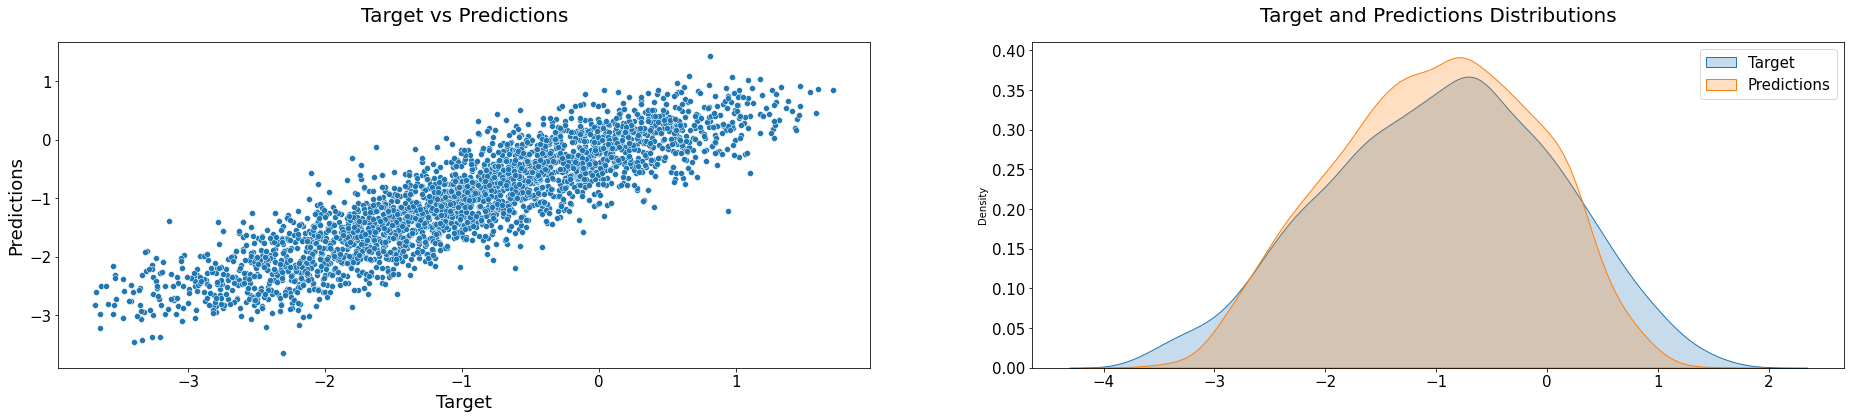

7548

In [18]:
roberta_parameters = {
    'model_name': 'roberta_base1',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 4,
    },
    'pretrained_model_path': ROBERTA_BASE_PRETRAINED_DIR,
    'max_seq_len': 256,
    'random_state': 42
}

roberta_pipeline = RoBERTaPipeline(**roberta_parameters)
roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del roberta_pipeline, roberta_parameters
gc.collect()


-------------------------------------------
Running PyTorch RoBERTa Model for Inference
-------------------------------------------
Fold 1 - RMSE: 0.481206
Fold 2 - RMSE: 0.524249
Fold 3 - RMSE: 0.49485
Fold 4 - RMSE: 0.477745
Fold 5 - RMSE: 0.489452
------------------------------
RoBERTa OOF RMSE: 0.493778
------------------------------


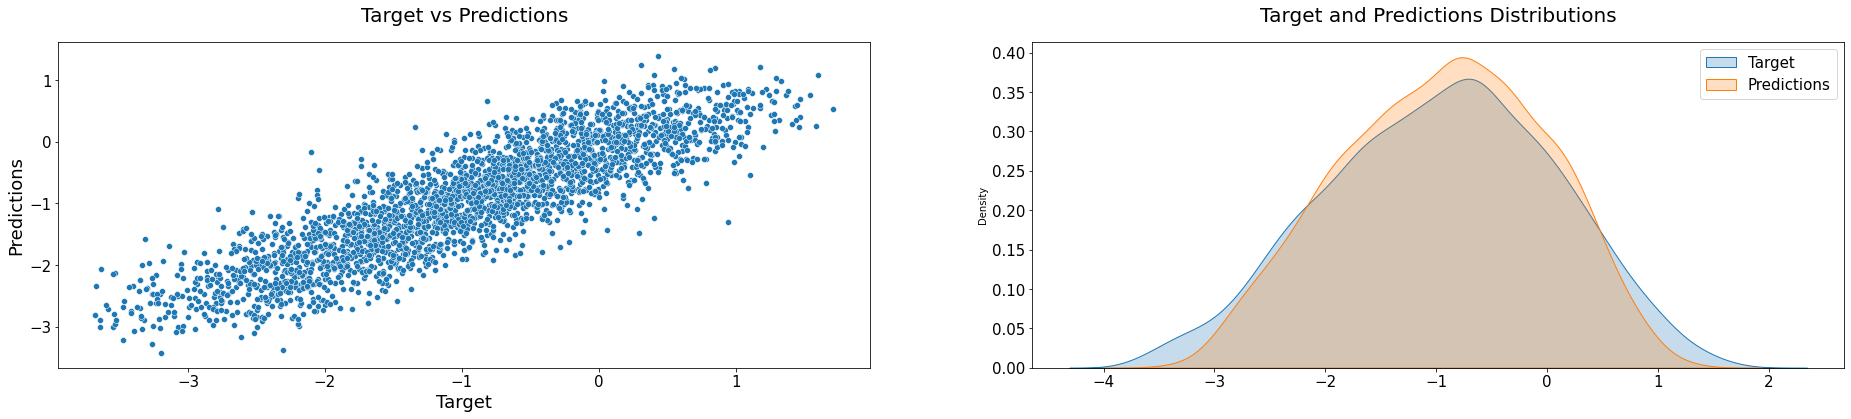

7078

In [19]:
roberta_parameters = {
    'model_name': 'roberta_base2',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 4,
    },
    'pretrained_model_path': ROBERTA_BASE_PRETRAINED_DIR,
    'max_seq_len': 256,
    'random_state': 42
}

roberta_pipeline = RoBERTaPipeline(**roberta_parameters)
roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del roberta_pipeline, roberta_parameters
gc.collect()


-------------------------------------------
Running PyTorch RoBERTa Model for Inference
-------------------------------------------
Fold 1 - RMSE: 0.480783
Fold 2 - RMSE: 0.514951
Fold 3 - RMSE: 0.490413
Fold 4 - RMSE: 0.474173
Fold 5 - RMSE: 0.490501
------------------------------
RoBERTa OOF RMSE: 0.49036
------------------------------


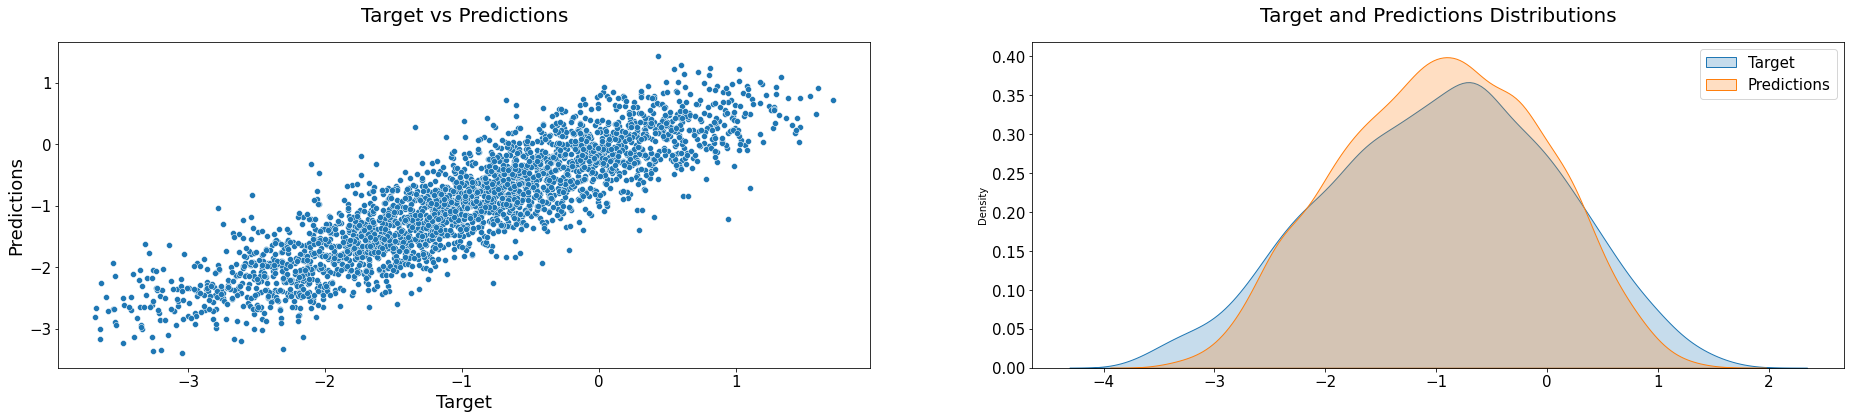

7078

In [20]:
roberta_parameters = {
    'model_name': 'roberta_base3',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 4,
    },
    'pretrained_model_path': ROBERTA_BASE_PRETRAINED_DIR,
    'max_seq_len': 256,
    'random_state': 42
}

roberta_pipeline = RoBERTaPipeline(**roberta_parameters)
roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del roberta_pipeline, roberta_parameters
gc.collect()


-------------------------------------------
Running PyTorch RoBERTa Model for Inference
-------------------------------------------
Fold 1 - RMSE: 0.486434
Fold 2 - RMSE: 0.515719
Fold 3 - RMSE: 0.486733
Fold 4 - RMSE: 0.475774
Fold 5 - RMSE: 0.494743
------------------------------
RoBERTa OOF RMSE: 0.492061
------------------------------


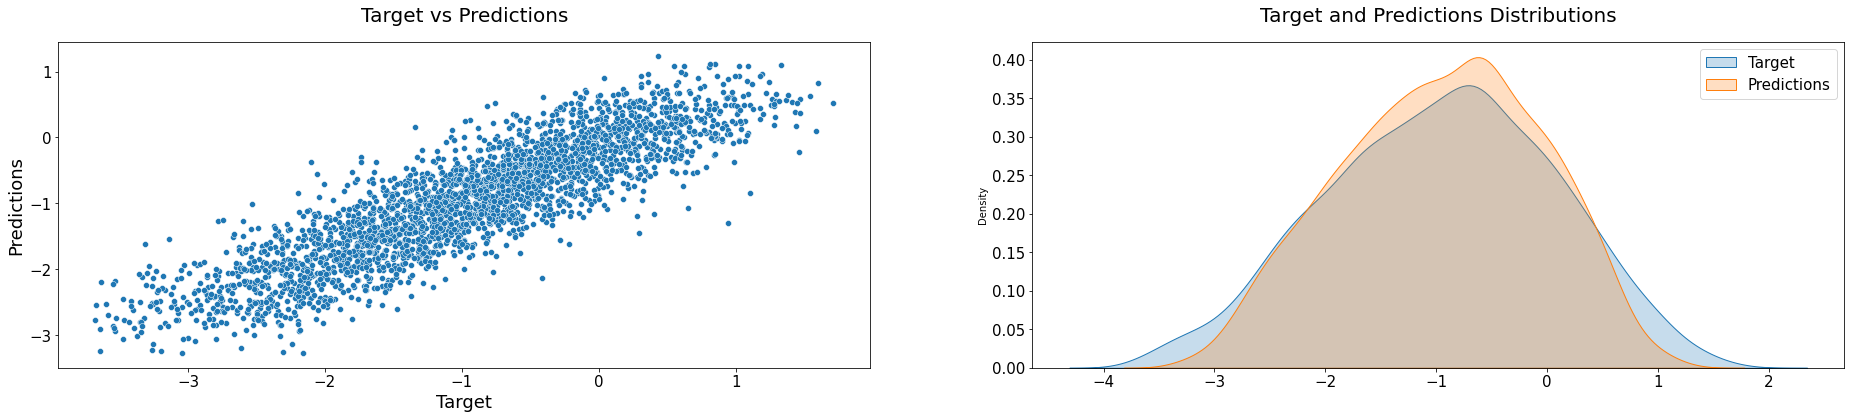

7078

In [21]:
roberta_parameters = {
    'model_name': 'roberta_base4',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 4,
    },
    'pretrained_model_path': ROBERTA_BASE_PRETRAINED_DIR,
    'max_seq_len': 256,
    'random_state': 42
}

roberta_pipeline = RoBERTaPipeline(**roberta_parameters)
roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del roberta_pipeline, roberta_parameters
gc.collect()

## DistilBERT

In [22]:
class DistilBERTModel(nn.Module):

    def __init__(self, pretrained_model_path, output_hidden_states=False):

        super(DistilBERTModel, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(pretrained_model_path, output_hidden_states=output_hidden_states)
        self.config = DistilBertConfig.from_pretrained(pretrained_model_path)
        self.config.update({'num_labels': 1})

        self.dropout = nn.Dropout(0.2)
        self.head = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.head)

    def _init_weights(self, module):

        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, input_ids, attention_mask):

        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]
        output = hidden_state[:, 0]
        output = self.head(self.dropout(output))
        output = output.view(-1)
        return output


In [23]:
class DistilBERTPipeline:
    
    def __init__(self, model_name, model_parameters, pretrained_model_path, max_seq_len, random_state):
        
        self.model_name = model_name
        self.model_parameters = model_parameters
        self.pretrained_model_path = pretrained_model_path
        self.max_seq_len = max_seq_len
        self.random_state = random_state
        
    def set_seed(self, seed):

        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
                
    def get_model(self):
        
        model = DistilBERTModel(pretrained_model_path=self.pretrained_model_path)
        return model
    
    def inference(self, X_train, y_train, X_test):
        
        print(f'\n{"-" * 46}\nRunning PyTorch DistilBERT Model for Inference\n{"-" * 46}')
        df_train[f'{self.model_name}_predictions'] = 0
        df_test[f'{self.model_name}_predictions'] = 0
        
        test_dataset = ExcerptDataset(
            excerpts=X_test,
            labels=None,
            tokenizer=DistilBertTokenizer.from_pretrained(self.pretrained_model_path),
            max_seq_len=self.max_seq_len
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=self.model_parameters['batch_size'], 
            sampler=SequentialSampler(test_dataset), 
            pin_memory=False, 
            drop_last=False, 
            num_workers=0
        )
        
        for fold in sorted(df_train['fold'].unique()):
            
            _, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index
            val_dataset = ExcerptDataset(
                excerpts=X_train.loc[val_idx],
                labels=y_train.loc[val_idx],
                tokenizer=DistilBertTokenizer.from_pretrained(self.pretrained_model_path),
                max_seq_len=self.max_seq_len
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.model_parameters['batch_size'],
                sampler=SequentialSampler(val_dataset),
                pin_memory=False,
                drop_last=False,
                num_workers=0
            )
            
            self.set_seed(self.random_state)
            model = self.get_model()
            model.load_state_dict(torch.load(f'../input/commonlit-readability-prize-dataset/models/distilbert/{self.model_name}_fold{fold}.bin'))
            model = model.cuda()
            model.eval()
            
            val_predictions = []

            with torch.no_grad():
                for idx, data in enumerate(val_loader):                    
                    input_ids, attention_mask = data['input_ids'], data['attention_mask']
                    input_ids, attention_mask = input_ids.cuda(), attention_mask.cuda()

                    output = model(input_ids=input_ids, attention_mask=attention_mask)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    val_predictions += output

                    del output, input_ids, attention_mask
                    torch.cuda.empty_cache()
                    
            test_predictions = []
                    
            with torch.no_grad():
                for idx, data in enumerate(test_loader):                    
                    input_ids, attention_mask = data['input_ids'], data['attention_mask']
                    input_ids, attention_mask = input_ids.cuda(), attention_mask.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    test_predictions += output
                    
                    del output, input_ids, attention_mask
                    torch.cuda.empty_cache()

            df_train.loc[val_idx, f'{self.model_name}_predictions'] = val_predictions
            df_test[f'{self.model_name}_predictions'] += (np.array(test_predictions) / df_train['fold'].nunique())
            fold_score = mean_squared_error(y_train.loc[val_idx], val_predictions, squared=False)
            print(f'Fold {int(fold)} - RMSE: {fold_score:.6}')
            
            del _, val_idx, val_dataset, val_loader, val_predictions, test_predictions, model
        del test_dataset, test_loader
            
        oof_score = mean_squared_error(df_train['target'], df_train[f'{self.model_name}_predictions'], squared=False)
        print(f'{"-" * 30}\nDistilBERT OOF RMSE: {oof_score:.6}\n{"-" * 30}')
        draw_predictions(df_train['target'], df_train[f'{self.model_name}_predictions'])


In [24]:
distilbert_parameters = {
    'model_name': 'distilbert_base1',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 4,
    },
    'pretrained_model_path': DISTILBERT_BASE_UNCASED_PRETRAINED_DIR,
    'max_seq_len': 256,
    'random_state': 42
}

distilbert_pipeline = DistilBERTPipeline(**distilbert_parameters)
#distilbert_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del distilbert_pipeline, distilbert_parameters
gc.collect()

20

## BART

In [25]:
class BARTModel(nn.Module):

    def __init__(self, pretrained_model_path, output_hidden_states=False):

        super(BARTModel, self).__init__()
        self.bart = BartModel.from_pretrained(pretrained_model_path, output_hidden_states=output_hidden_states)
        self.config = BartConfig.from_pretrained(pretrained_model_path)
        self.config.update({'num_labels': 1})

        self.dropout = nn.Dropout(0.2)
        self.head = nn.Linear(self.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):

        outputs = self.bart(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = outputs[0]
        output = hidden_state[:, 0]
        output = self.head(self.dropout(output))
        output = output.view(-1)
        return output


In [26]:
class BARTPipeline:
    
    def __init__(self, model_name, model_parameters, pretrained_model_path, max_seq_len, random_state):
        
        self.model_name = model_name
        self.model_parameters = model_parameters
        self.pretrained_model_path = pretrained_model_path
        self.max_seq_len = max_seq_len
        self.random_state = random_state
        
    def set_seed(self, seed):

        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
                
    def get_model(self):
        
        model = BARTModel(pretrained_model_path=self.pretrained_model_path)
        return model
    
    def inference(self, X_train, y_train, X_test):
        
        print(f'\n{"-" * 40}\nRunning PyTorch BART Model for Inference\n{"-" * 40}')
        df_train[f'{self.model_name}_predictions'] = 0
        df_test[f'{self.model_name}_predictions'] = 0
        
        test_dataset = ExcerptDataset(
            excerpts=X_test,
            labels=None,
            tokenizer=BartTokenizer.from_pretrained(self.pretrained_model_path),
            max_seq_len=self.max_seq_len
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=self.model_parameters['batch_size'], 
            sampler=SequentialSampler(test_dataset), 
            pin_memory=False, 
            drop_last=False, 
            num_workers=0
        )
        
        for fold in sorted(df_train['fold'].unique()):
            
            _, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index
            val_dataset = ExcerptDataset(
                excerpts=X_train.loc[val_idx],
                labels=y_train.loc[val_idx],
                tokenizer=BartTokenizer.from_pretrained(self.pretrained_model_path),
                max_seq_len=self.max_seq_len
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.model_parameters['batch_size'],
                sampler=SequentialSampler(val_dataset),
                pin_memory=False,
                drop_last=False,
                num_workers=0
            )
            
            self.set_seed(self.random_state)
            model = self.get_model()
            model.load_state_dict(torch.load(f'../input/commonlit-readability-prize-dataset/models/bart/{self.model_name}_fold{fold}.bin'))
            model = model.cuda()
            model.eval()
            
            val_predictions = []

            with torch.no_grad():
                for idx, data in enumerate(val_loader):                    
                    input_ids, attention_mask = data['input_ids'], data['attention_mask']
                    input_ids, attention_mask = input_ids.cuda(), attention_mask.cuda()

                    output = model(input_ids=input_ids, attention_mask=attention_mask)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    val_predictions += output

                    del output, input_ids, attention_mask
                    torch.cuda.empty_cache()
                    
            test_predictions = []
                    
            with torch.no_grad():
                for idx, data in enumerate(test_loader):                    
                    input_ids, attention_mask = data['input_ids'], data['attention_mask']
                    input_ids, attention_mask = input_ids.cuda(), attention_mask.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    test_predictions += output
                    
                    del output, input_ids, attention_mask
                    torch.cuda.empty_cache()

            df_train.loc[val_idx, f'{self.model_name}_predictions'] = val_predictions
            df_test[f'{self.model_name}_predictions'] += (np.array(test_predictions) / df_train['fold'].nunique())
            fold_score = mean_squared_error(y_train.loc[val_idx], val_predictions, squared=False)
            print(f'Fold {int(fold)} - RMSE: {fold_score:.6}')
            
            del _, val_idx, val_dataset, val_loader, val_predictions, test_predictions, model
        del test_dataset, test_loader
            
        oof_score = mean_squared_error(df_train['target'], df_train[f'{self.model_name}_predictions'], squared=False)
        print(f'{"-" * 30}\nBART OOF RMSE: {oof_score:.6}\n{"-" * 30}')
        draw_predictions(df_train['target'], df_train[f'{self.model_name}_predictions'])


In [27]:
bart_parameters = {
    'model_name': 'bart_base1',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 4,
    },
    'pretrained_model_path': BART_BASE_PRETRAINED_DIR,
    'max_seq_len': 256,
    'random_state': 42
}

bart_pipeline = BARTPipeline(**bart_parameters)
#bart_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del bart_pipeline, bart_parameters
gc.collect()

20

## Public Models

### maunish

In [28]:
class AttentionHead(nn.Module):
    
    def __init__(self, in_features, hidden_dim, num_targets):
        
        super(AttentionHead, self).__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

    def forward(self, features):
        
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)
        return context_vector
    
class MaunishRoBERTaModel(nn.Module):
    
    def __init__(self, pretrained_model_path):
        
        super(MaunishRoBERTaModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model_path)    
        self.head = AttentionHead(768, 768, 1)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.head.out_features, 1)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        
        x = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)[0]
        x = self.head(x)
        x = self.linear(x)
        return x


In [29]:
class MaunishRoBERTaPipeline:
    
    def __init__(self, model_name, model_parameters, pretrained_model_path, max_seq_len, random_state):
        
        self.model_name = model_name
        self.model_parameters = model_parameters
        self.pretrained_model_path = pretrained_model_path
        self.max_seq_len = max_seq_len
        self.random_state = random_state
        
    def set_seed(self, seed):
        
        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    def get_model(self):
        
        model = MaunishRoBERTaModel(pretrained_model_path=self.pretrained_model_path)
        return model
        
    def inference(self, X_train, y_train, X_test):
        
        print(f'{"-" * 43}\nRunning Maunish RoBERTa Model for Inference\n{"-" * 43}')
        
        df_train[f'maunish_{self.model_name}_predictions'] = 0
        df_test[f'maunish_{self.model_name}_predictions'] = 0
        
        test_dataset = ExcerptDataset(
            excerpts=X_test,
            labels=None,
            tokenizer=RobertaTokenizer.from_pretrained(self.pretrained_model_path),
            max_seq_len=self.max_seq_len
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=self.model_parameters['batch_size'], 
            sampler=SequentialSampler(test_dataset), 
            pin_memory=False, 
            drop_last=False, 
            num_workers=0
        )
        
        for fold in sorted(df_train['fold'].unique()):
            
            _, val_idx = df_train.loc[df_train['fold'] != fold].index, df_train.loc[df_train['fold'] == fold].index
            val_dataset = ExcerptDataset(
                excerpts=X_train.loc[val_idx],
                labels=y_train.loc[val_idx],
                tokenizer=RobertaTokenizer.from_pretrained(self.pretrained_model_path),
                max_seq_len=self.max_seq_len
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.model_parameters['batch_size'],
                sampler=SequentialSampler(val_dataset),
                pin_memory=False,
                drop_last=False,
                num_workers=0
            )
            
            self.set_seed(self.random_state)
            model = MaunishRoBERTaModel(self.pretrained_model_path)
            model.load_state_dict(torch.load(f'../input/commonlit-readability-prize-dataset/models/maunish_roberta/{self.model_name}_fold{fold}.bin'))
            model = model.cuda()
            model.eval()
            
            val_predictions = []
            
            with torch.no_grad():
                for idx, X in enumerate(val_loader):
                    
                    input_ids, attention_mask, token_type_ids = X['input_ids'], X['attention_mask'], X['token_type_ids']
                    input_ids, attention_mask, token_type_ids = input_ids.cuda(), attention_mask.cuda(), token_type_ids.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    val_predictions += output
                    
                    del output, input_ids, attention_mask, token_type_ids
                    torch.cuda.empty_cache()
                    
            test_predictions = []
                    
            with torch.no_grad():
                for idx, X in enumerate(test_loader):
                    
                    input_ids, attention_mask, token_type_ids = X['input_ids'], X['attention_mask'], X['token_type_ids']
                    input_ids, attention_mask, token_type_ids = input_ids.cuda(), attention_mask.cuda(), token_type_ids.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    test_predictions += output
                    
                    del output, input_ids, attention_mask, token_type_ids
                    torch.cuda.empty_cache()

            df_train.loc[val_idx, f'maunish_{self.model_name}_predictions'] = val_predictions
            df_test[f'maunish_{self.model_name}_predictions'] += (np.array(test_predictions) / df_train['fold'].nunique())
            fold_score = mean_squared_error(df_train.loc[val_idx, 'target'], df_train.loc[val_idx, f'maunish_{self.model_name}_predictions'], squared=False)
            print(f'Fold {int(fold)} - RMSE: {fold_score:.6}')
            
            del _, val_idx, val_dataset, val_loader, val_predictions, test_predictions, model
            
        oof_score = mean_squared_error(df_train['target'], df_train[f'maunish_{self.model_name}_predictions'], squared=False)
        print(f'{"-" * 30}\nMaunish RoBERTa OOF RMSE: {oof_score:.6}\n{"-" * 30}')
        draw_predictions(df_train['target'], df_train[f'{self.model_name}_predictions'])


-------------------------------------------
Running Maunish RoBERTa Model for Inference
-------------------------------------------
Fold 1 - RMSE: 0.478458
Fold 2 - RMSE: 0.506665
Fold 3 - RMSE: 0.505003
Fold 4 - RMSE: 0.471869
Fold 5 - RMSE: 0.510774
------------------------------
Maunish RoBERTa OOF RMSE: 0.494809
------------------------------


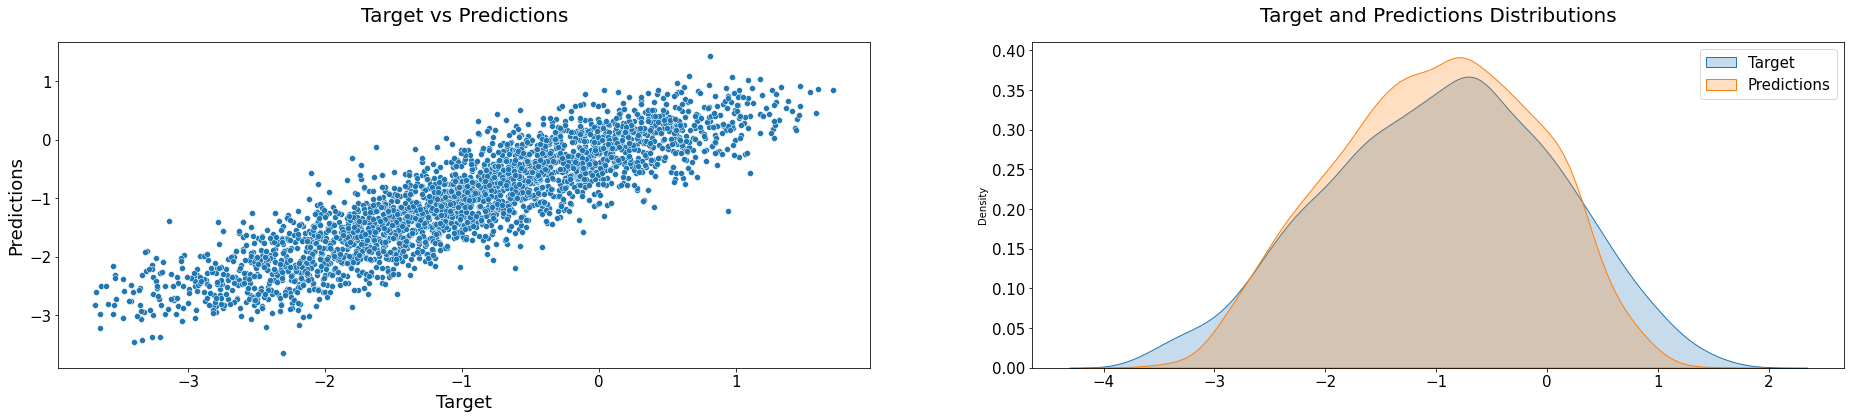

7571

In [30]:
maunish_roberta_parameters = {
    'model_name': 'roberta_base1',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 0
    },
    'pretrained_model_path': ROBERTA_BASE_PRETRAINED_DIR,
    'max_seq_len': 250,
    'random_state': 42
}

maunish_roberta_pipeline = MaunishRoBERTaPipeline(**maunish_roberta_parameters)
maunish_roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del maunish_roberta_pipeline, maunish_roberta_parameters
gc.collect()

### rhtsingh

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=2021)
        
for fold, (_, val_idx) in enumerate(kf.split(df_train), 1):
    df_train.loc[val_idx, 'rhtsingh_fold'] = fold

df_train['rhtsingh_fold'] = df_train['rhtsingh_fold'].astype(np.uint8)

In [32]:
class RhtsinghRoBERTaModel(nn.Module):
    
    def __init__(self, pretrained_model_path, multisample_dropout=False, output_hidden_states=False):
        
        super(RhtsinghRoBERTaModel, self).__init__()
        self.roberta = RobertaModel.from_pretrained(pretrained_model_path, output_hidden_states=output_hidden_states)
        self.config = RobertaConfig.from_pretrained(pretrained_model_path)
        self.config.update({'num_labels': 1})
        
        self.layer_norm = nn.LayerNorm(self.config.hidden_size)
        if multisample_dropout:
            self.dropouts = nn.ModuleList([nn.Dropout(0.5) for _ in range(5)])
        else:
            self.dropouts = nn.ModuleList([nn.Dropout(0.3)])
        self.regressor = nn.Linear(self.config.hidden_size, 1)
        self._init_weights(self.layer_norm)
        self._init_weights(self.regressor)
 
    def _init_weights(self, module):
        
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
 
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        
        outputs = self.roberta(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        sequence_output = outputs[1]
        sequence_output = self.layer_norm(sequence_output)
 
        for i, dropout in enumerate(self.dropouts):
            if i == 0:
                logits = self.regressor(dropout(sequence_output))
            else:
                logits += self.regressor(dropout(sequence_output))
        
        logits /= len(self.dropouts)
 
        loss = None
        if labels is not None:
            loss_fn = torch.nn.MSELoss()
            logits = logits.view(-1).to(labels.dtype)
            loss = torch.sqrt(loss_fn(logits, labels.view(-1)))
        
        output = (logits,) + outputs[1:]
        return ((loss,) + output) if loss is not None else output


In [33]:
class RhtsinghRoBERTaPipeline:
    
    def __init__(self, model_name, model_parameters, max_seq_len, pretrained_model_path, random_state):
        
        self.model_name = model_name
        self.model_parameters = model_parameters
        self.pretrained_model_path = pretrained_model_path
        self.max_seq_len = max_seq_len
        self.random_state = random_state
        
    def set_seed(self, seed):
        
        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    def get_model(self):

        model = RhtsinghRoBERTaModel(pretrained_model_path=self.pretrained_model_path)
        return model
    
    def inference(self, X_train, y_train, X_test):
        
        print(f'{"-" * 44}\nRunning rhtsingh RoBERTa Model for Inference\n{"-" * 44}')
        
        df_train[f'rhtsingh_{self.model_name}_predictions'] = 0
        df_test[f'rhtsingh_{self.model_name}_predictions'] = 0
        
        test_dataset = ExcerptDataset(
            excerpts=X_test,
            labels=None,
            tokenizer=RobertaTokenizer.from_pretrained(self.pretrained_model_path),
            max_seq_len=self.max_seq_len
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=self.model_parameters['batch_size'], 
            sampler=SequentialSampler(test_dataset), 
            pin_memory=False, 
            drop_last=False, 
            num_workers=0
        )
        
        for fold in sorted(df_train['rhtsingh_fold'].unique()):
            
            _, val_idx = df_train.loc[df_train['rhtsingh_fold'] != fold].index, df_train.loc[df_train['rhtsingh_fold'] == fold].index
            val_dataset = ExcerptDataset(
                excerpts=X_train.loc[val_idx],
                labels=y_train.loc[val_idx],
                tokenizer=RobertaTokenizer.from_pretrained(self.pretrained_model_path),
                max_seq_len=self.max_seq_len
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.model_parameters['batch_size'],
                sampler=SequentialSampler(val_dataset),
                pin_memory=False,
                drop_last=False,
                num_workers=0
            )
            
            self.set_seed(self.random_state)
            model = self.get_model()
            model.load_state_dict(torch.load(f'../input/commonlit-readability-prize-dataset/models/rhtsingh_roberta/{self.model_name}_fold{fold}.bin'))
            model = model.cuda()
            model.eval()
            
            val_predictions = []
            
            with torch.no_grad():
                for idx, X in enumerate(val_loader):
                    
                    input_ids, attention_mask, token_type_ids = X['input_ids'], X['attention_mask'], X['token_type_ids']
                    input_ids, attention_mask, token_type_ids = input_ids.cuda(), attention_mask.cuda(), token_type_ids.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                    output = output[0].detach().cpu().numpy().squeeze().tolist()
                    val_predictions += output
                    
                    del output, input_ids, attention_mask, token_type_ids
                    torch.cuda.empty_cache()
                    
            test_predictions = []
                    
            with torch.no_grad():
                for idx, X in enumerate(test_loader):
                    
                    input_ids, attention_mask, token_type_ids = X['input_ids'], X['attention_mask'], X['token_type_ids']
                    input_ids, attention_mask, token_type_ids = input_ids.cuda(), attention_mask.cuda(), token_type_ids.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
                    output = output[0].detach().cpu().numpy().squeeze().tolist()
                    test_predictions += output
                    
                    del output, input_ids, attention_mask, token_type_ids
                    torch.cuda.empty_cache()

            df_train.loc[val_idx, f'rhtsingh_{self.model_name}_predictions'] = val_predictions
            df_test[f'rhtsingh_{self.model_name}_predictions'] += (np.array(test_predictions) / df_train['fold'].nunique())
            fold_score = mean_squared_error(df_train.loc[val_idx, 'target'], df_train.loc[val_idx, f'rhtsingh_{self.model_name}_predictions'], squared=False)
            print(f'Fold {int(fold)} - RMSE: {fold_score:.6}')
            
            del _, val_idx, val_dataset, val_loader, val_predictions, test_predictions, model
            
        oof_score = mean_squared_error(df_train['target'], df_train[f'rhtsingh_{self.model_name}_predictions'], squared=False)
        print(f'{"-" * 30}\nrhtsingh RoBERTa OOF RMSE: {oof_score:.6}\n{"-" * 30}')
        draw_predictions(df_train['target'], df_train[f'rhtsingh_{self.model_name}_predictions'])


--------------------------------------------
Running rhtsingh RoBERTa Model for Inference
--------------------------------------------
Fold 1 - RMSE: 0.489957
Fold 2 - RMSE: 0.476889
Fold 3 - RMSE: 0.472358
Fold 4 - RMSE: 0.506478
Fold 5 - RMSE: 0.457965
------------------------------
rhtsingh RoBERTa OOF RMSE: 0.481018
------------------------------


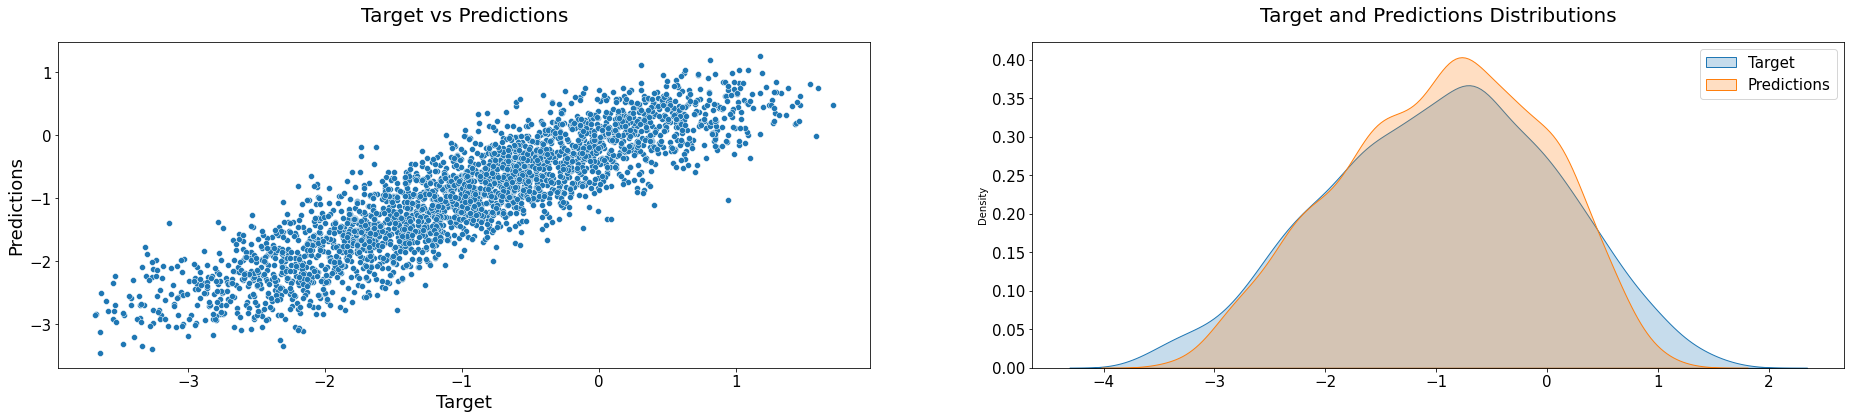

7513

In [34]:
rhtsingh_roberta_parameters = {
    'model_name': 'roberta_base1',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 0
    },
    'pretrained_model_path': ROBERTA_BASE_PRETRAINED_DIR,
    'max_seq_len': 250,
    'random_state': 2021
}

rhtsingh_roberta_pipeline = RhtsinghRoBERTaPipeline(**rhtsingh_roberta_parameters)
rhtsingh_roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del rhtsingh_roberta_pipeline, rhtsingh_roberta_parameters
gc.collect()

--------------------------------------------
Running rhtsingh RoBERTa Model for Inference
--------------------------------------------
Fold 1 - RMSE: 0.482936
Fold 2 - RMSE: 0.46186
Fold 3 - RMSE: 0.486541
Fold 4 - RMSE: 0.509472
Fold 5 - RMSE: 0.454463
------------------------------
rhtsingh RoBERTa OOF RMSE: 0.479459
------------------------------


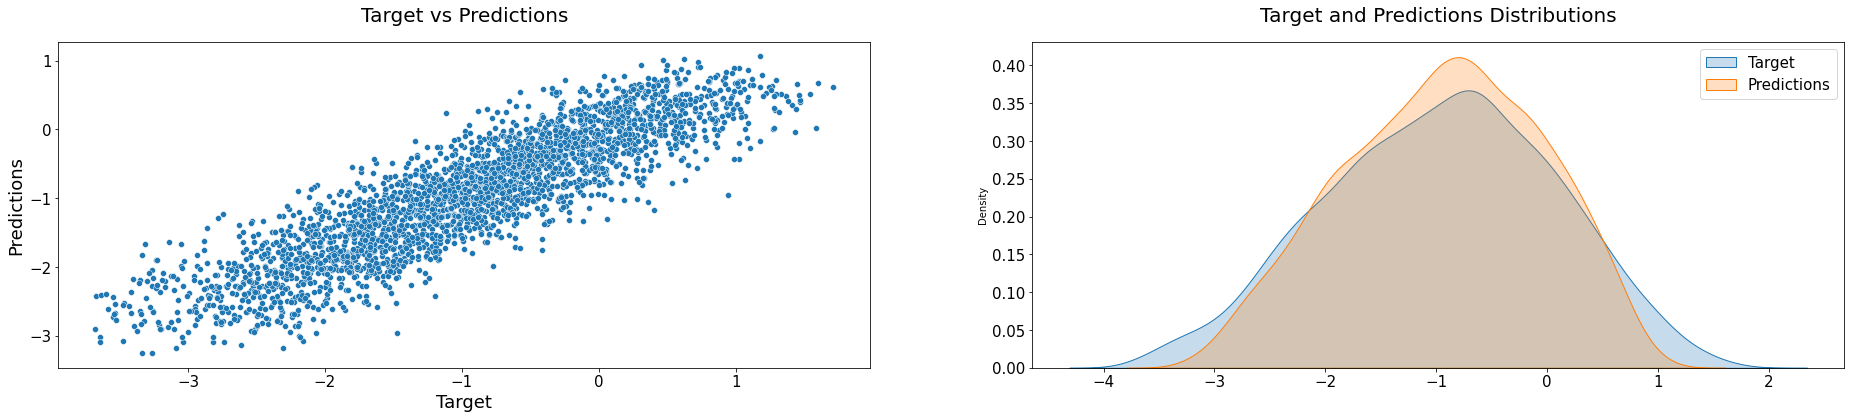

9469

In [35]:
rhtsingh_roberta_parameters = {
    'model_name': 'roberta_large1',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 0
    },
    'pretrained_model_path': ROBERTA_LARGE_PRETRAINED_DIR,
    'max_seq_len': 250,
    'random_state': 2021
}

rhtsingh_roberta_pipeline = RhtsinghRoBERTaPipeline(**rhtsingh_roberta_parameters)
rhtsingh_roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del rhtsingh_roberta_pipeline, rhtsingh_roberta_parameters
gc.collect()

--------------------------------------------
Running rhtsingh RoBERTa Model for Inference
--------------------------------------------
Fold 1 - RMSE: 0.484303
Fold 2 - RMSE: 0.476664
Fold 3 - RMSE: 0.487326
Fold 4 - RMSE: 0.508633
Fold 5 - RMSE: 0.452981
------------------------------
rhtsingh RoBERTa OOF RMSE: 0.482326
------------------------------


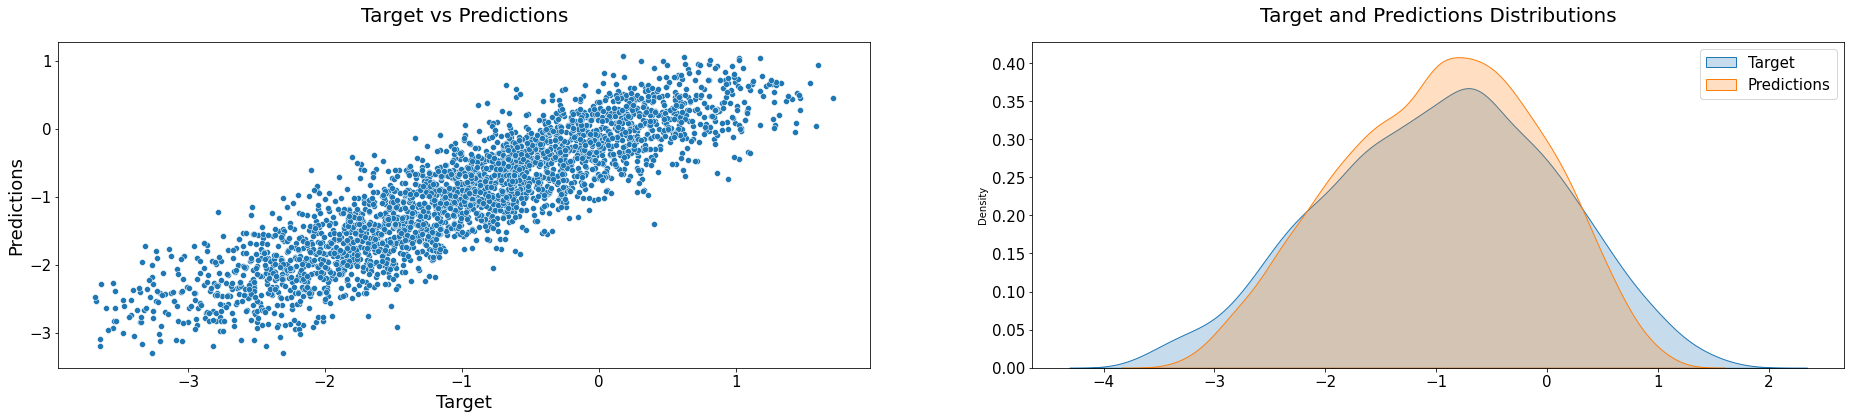

9469

In [36]:
rhtsingh_roberta_parameters = {
    'model_name': 'roberta_large2',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 0
    },
    'pretrained_model_path': ROBERTA_LARGE_PRETRAINED_DIR,
    'max_seq_len': 250,
    'random_state': 2021
}

rhtsingh_roberta_pipeline = RhtsinghRoBERTaPipeline(**rhtsingh_roberta_parameters)
rhtsingh_roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del rhtsingh_roberta_pipeline, rhtsingh_roberta_parameters
gc.collect()

### andretugan

In [37]:
filtered_ids = df_train.drop(df_train[(df_train.target == 0) & (df_train.standard_error == 0)].index).reset_index(drop=True)[['id']]
kf = KFold(n_splits=5, shuffle=True, random_state=1000)
        
for fold, (_, val_idx) in enumerate(kf.split(filtered_ids), 1):
    filtered_ids.loc[val_idx, 'andretugan_fold'] = fold
    
filtered_ids['andretugan_fold'] = filtered_ids['andretugan_fold'].astype(np.uint8)
df_train = df_train.merge(filtered_ids, how='left', on='id')

In [38]:
class AndretuganRoBERTaModel(nn.Module):
    
    def __init__(self, pretrained_model_path):
        
        super(AndretuganRoBERTaModel, self).__init__()
        self.config = RobertaConfig.from_pretrained(pretrained_model_path)
        self.config.update({'output_hidden_states': True, 'hidden_dropout_prob': 0.0, 'layer_norm_eps': 1e-7})                       
        self.roberta = RobertaModel.from_pretrained(pretrained_model_path, config=self.config)  
            
        self.attention = nn.Sequential(            
            nn.Linear(768, 512),            
            nn.Tanh(),                       
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )        

        self.regressor = nn.Sequential(                        
            nn.Linear(768, 1)                        
        )
        
    def forward(self, input_ids, attention_mask):
        
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)        
        last_layer_hidden_states = roberta_output.hidden_states[-1]
        weights = self.attention(last_layer_hidden_states)
        context_vector = torch.sum(weights * last_layer_hidden_states, dim=1)        
        return self.regressor(context_vector)


In [39]:
class AndretuganRoBERTaPipeline:
    
    def __init__(self, model_name, model_parameters, max_seq_len, pretrained_model_path, random_state):
        
        self.model_name = model_name
        self.model_parameters = model_parameters
        self.pretrained_model_path = pretrained_model_path
        self.max_seq_len = max_seq_len
        self.random_state = random_state
        
    def set_seed(self, seed):
        
        os.environ['PYTHONHASHSEED'] = str(seed)
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    def get_model(self):

        model = AndretuganRoBERTaModel(pretrained_model_path=self.pretrained_model_path)
        return model
    
    def inference(self, X_train, y_train, X_test):
        
        print(f'{"-" * 46}\nRunning andretugan RoBERTa Model for Inference\n{"-" * 46}')
        
        df_train[f'andretugan_{self.model_name}_predictions'] = 0
        df_test[f'andretugan_{self.model_name}_predictions'] = 0
        
        test_dataset = ExcerptDataset(
            excerpts=X_test,
            labels=None,
            tokenizer=RobertaTokenizer.from_pretrained(self.pretrained_model_path),
            max_seq_len=self.max_seq_len
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=self.model_parameters['batch_size'], 
            sampler=SequentialSampler(test_dataset), 
            pin_memory=False, 
            drop_last=False, 
            num_workers=0
        )
        
        for fold in sorted(df_train['andretugan_fold'].unique()):
            
            if np.isnan(fold):
                continue
            
            _, val_idx = df_train.loc[df_train['andretugan_fold'] != fold].index, df_train.loc[df_train['andretugan_fold'] == fold].index
            val_dataset = ExcerptDataset(
                excerpts=X_train.loc[val_idx],
                labels=y_train.loc[val_idx],
                tokenizer=RobertaTokenizer.from_pretrained(self.pretrained_model_path),
                max_seq_len=self.max_seq_len
            )
            val_loader = DataLoader(
                val_dataset,
                batch_size=self.model_parameters['batch_size'],
                sampler=SequentialSampler(val_dataset),
                pin_memory=False,
                drop_last=False,
                num_workers=0
            )
            
            self.set_seed(self.random_state)
            model = self.get_model()
            model.load_state_dict(torch.load(f'../input/commonlit-readability-prize-dataset/models/andretugan_roberta/{self.model_name}_fold{int(fold)}.pth'))
            model = model.cuda()
            model.eval()
            
            val_predictions = []
            
            with torch.no_grad():
                for idx, X in enumerate(val_loader):
                    
                    input_ids, attention_mask = X['input_ids'], X['attention_mask']
                    input_ids, attention_mask = input_ids.cuda(), attention_mask.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    val_predictions += output
                    
                    del output, input_ids, attention_mask
                    torch.cuda.empty_cache()
                    
            test_predictions = []
                    
            with torch.no_grad():
                for idx, X in enumerate(test_loader):
                    
                    input_ids, attention_mask = X['input_ids'], X['attention_mask']
                    input_ids, attention_mask = input_ids.cuda(), attention_mask.cuda()
                    
                    output = model(input_ids=input_ids, attention_mask=attention_mask)
                    output = output.detach().cpu().numpy().squeeze().tolist()
                    test_predictions += output
                    
                    del output, input_ids, attention_mask
                    torch.cuda.empty_cache()

            df_train.loc[val_idx, f'andretugan_{self.model_name}_predictions'] = val_predictions
            df_test[f'andretugan_{self.model_name}_predictions'] += (np.array(test_predictions) / df_train['fold'].nunique())
            fold_score = mean_squared_error(df_train.loc[val_idx, 'target'], df_train.loc[val_idx, f'andretugan_{self.model_name}_predictions'], squared=False)
            print(f'Fold {int(fold)} - RMSE: {fold_score:.6}')
            
            del _, val_idx, val_dataset, val_loader, val_predictions, test_predictions, model
            
        oof_score = mean_squared_error(df_train['target'], df_train[f'andretugan_{self.model_name}_predictions'], squared=False)
        print(f'{"-" * 30}\nandretugan RoBERTa OOF RMSE: {oof_score:.6}\n{"-" * 30}')
        draw_predictions(df_train['target'], df_train[f'andretugan_{self.model_name}_predictions'])


----------------------------------------------
Running andretugan RoBERTa Model for Inference
----------------------------------------------
Fold 1 - RMSE: 0.480838
Fold 2 - RMSE: 0.46184
Fold 3 - RMSE: 0.497321
Fold 4 - RMSE: 0.492437
Fold 5 - RMSE: 0.48325
------------------------------
andretugan RoBERTa OOF RMSE: 0.483203
------------------------------


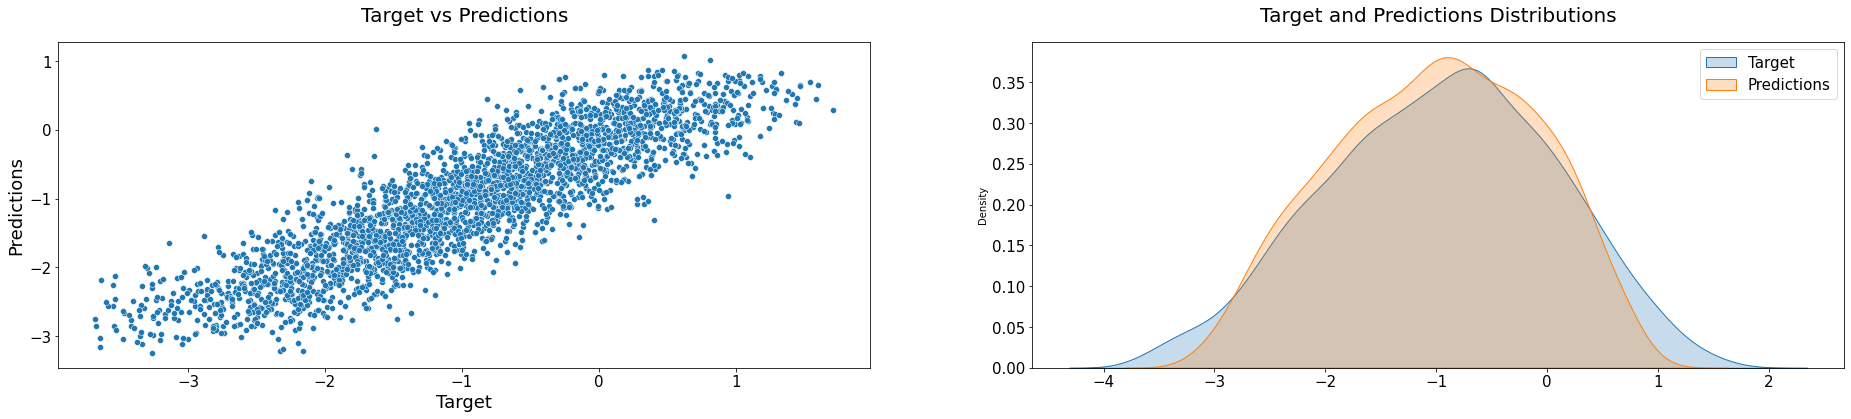

7069

In [40]:
andretugan_roberta_parameters = {
    'model_name': 'roberta_base1',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 0
    },
    'pretrained_model_path': ROBERTA_BASE_PRETRAINED_DIR,
    'max_seq_len': 248,
    'random_state': 2021
}

andretugan_roberta_pipeline = AndretuganRoBERTaPipeline(**andretugan_roberta_parameters)
andretugan_roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del andretugan_roberta_pipeline, andretugan_roberta_parameters
gc.collect()

----------------------------------------------
Running andretugan RoBERTa Model for Inference
----------------------------------------------
Fold 1 - RMSE: 0.484918
Fold 2 - RMSE: 0.467663
Fold 3 - RMSE: 0.486298
Fold 4 - RMSE: 0.476822
Fold 5 - RMSE: 0.483034
------------------------------
andretugan RoBERTa OOF RMSE: 0.479711
------------------------------


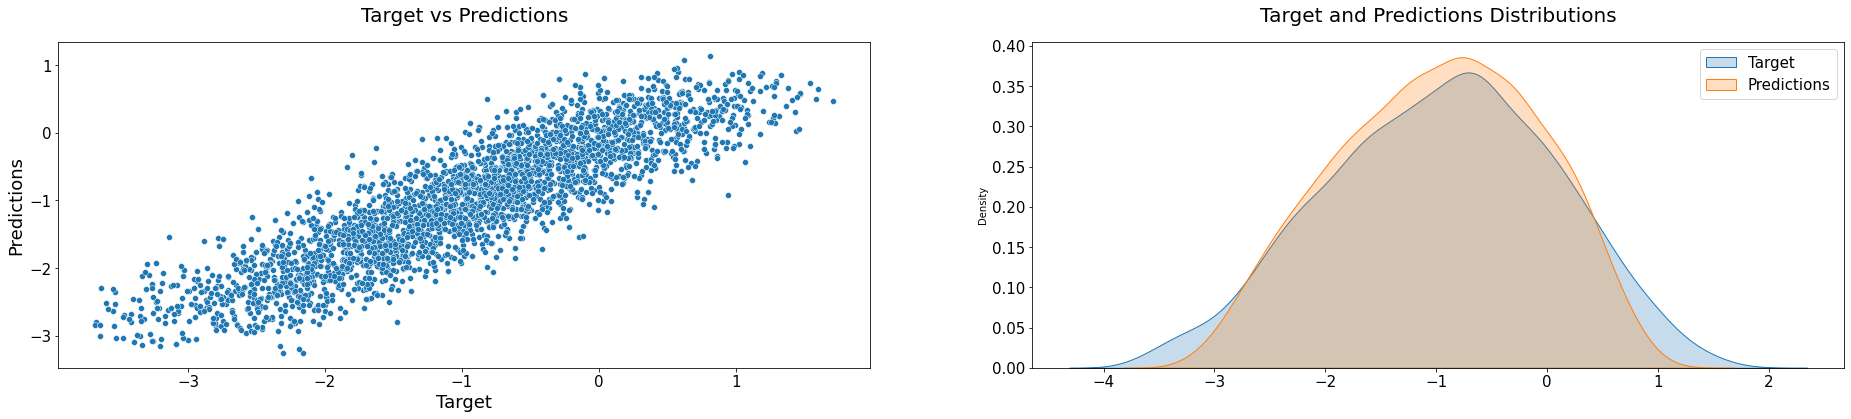

7078

In [41]:
andretugan_roberta_parameters = {
    'model_name': 'roberta_base2',
    'model_parameters': {
        'batch_size': 8,
        'num_workers': 0
    },
    'pretrained_model_path': ROBERTA_BASE_PRETRAINED_DIR,
    'max_seq_len': 248,
    'random_state': 2021
}

andretugan_roberta_pipeline = AndretuganRoBERTaPipeline(**andretugan_roberta_parameters)
andretugan_roberta_pipeline.inference(X_train=df_train['excerpt'], y_train=df_train['target'], X_test=df_test['excerpt'])

del andretugan_roberta_pipeline, andretugan_roberta_parameters
gc.collect()

## Post-processing

In [42]:
prediction_columns = [col for col in df_train.columns if col.endswith('predictions')]
df_train_predictions = df_train[['excerpt', 'target'] + prediction_columns].copy(deep=True)
df_test_predictions = df_test[['excerpt'] + prediction_columns].copy(deep=True)
print(f'There are {len(prediction_columns)} prediction columns\n{prediction_columns}')

There are 10 prediction columns
['roberta_base1_predictions', 'roberta_base2_predictions', 'roberta_base3_predictions', 'roberta_base4_predictions', 'maunish_roberta_base1_predictions', 'rhtsingh_roberta_base1_predictions', 'rhtsingh_roberta_large1_predictions', 'rhtsingh_roberta_large2_predictions', 'andretugan_roberta_base1_predictions', 'andretugan_roberta_base2_predictions']


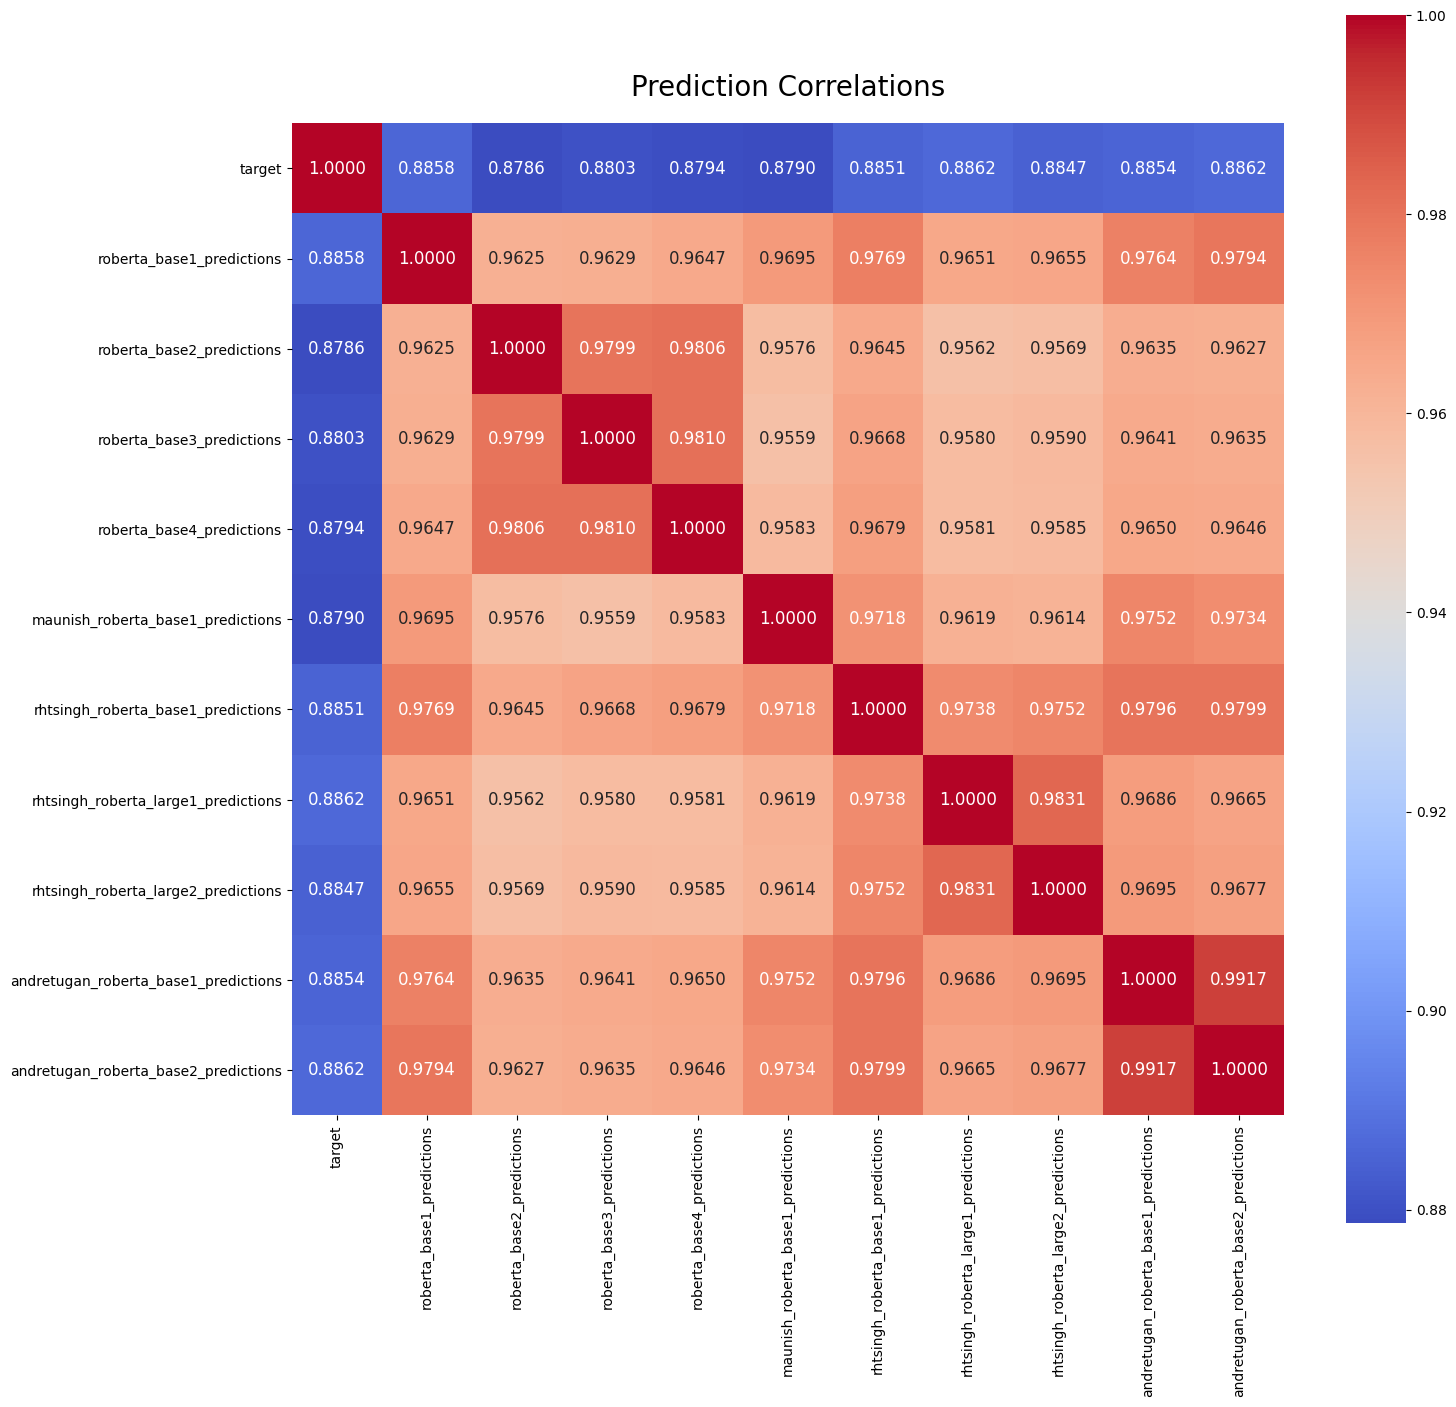

In [43]:
fig = plt.figure(figsize=(16, 16), dpi=100)
sns.heatmap(df_train_predictions.corr(),
            annot=True,
            square=True,
            cmap='coolwarm',
            annot_kws={'size': 12},
            fmt='.4f')

plt.tick_params(axis='x', labelsize=10, rotation=90)
plt.tick_params(axis='y', labelsize=10, rotation=0)
plt.title('Prediction Correlations', size=20, pad=20)

plt.show()

## Stacking

------------------------------
Running Ridge Regression Model
------------------------------
Fold 1 - X_trn Shape: (2267, 540) - X_val Shape: (567, 540) - RMSE: 0.456407
Fold 2 - X_trn Shape: (2267, 540) - X_val Shape: (567, 540) - RMSE: 0.479828
Fold 3 - X_trn Shape: (2267, 540) - X_val Shape: (567, 540) - RMSE: 0.456331
Fold 4 - X_trn Shape: (2267, 540) - X_val Shape: (567, 540) - RMSE: 0.42821
Fold 5 - X_trn Shape: (2268, 540) - X_val Shape: (566, 540) - RMSE: 0.468312
--------------------------------------------------
Ridge Regression - OOF RMSE: 0.458136
--------------------------------------------------


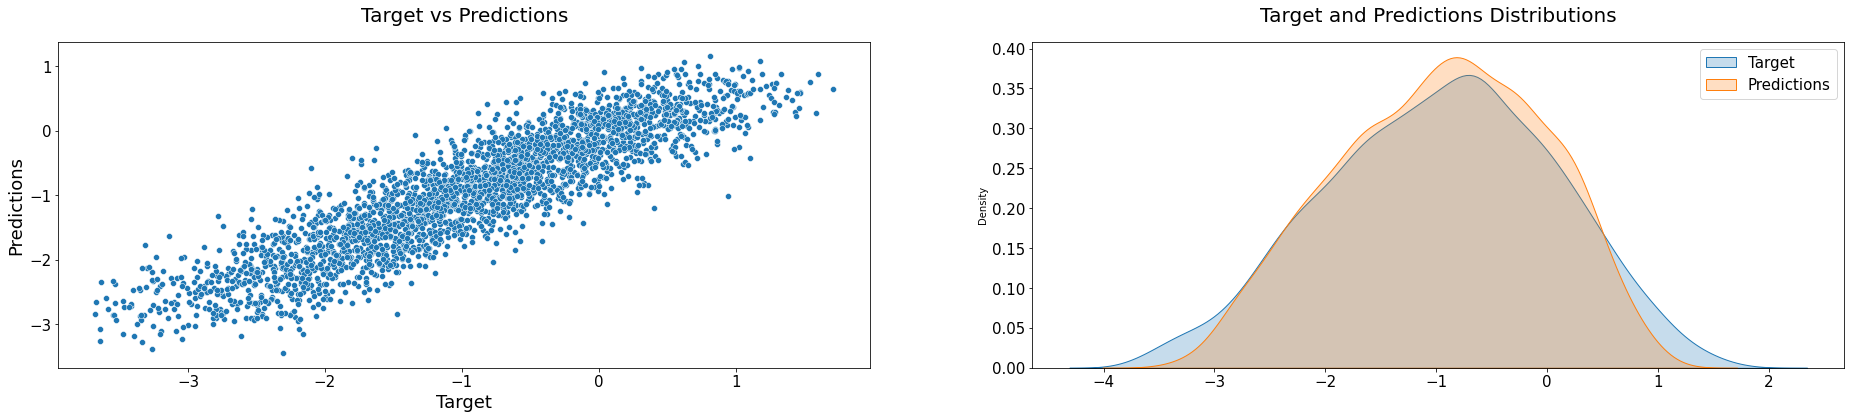

In [44]:
readability_features_scale = 10
use_features_scale = 2

X_train = np.hstack([
    df_train[prediction_columns].values,
    df_train[readability_features].values / readability_features_scale,
    train_use_features / use_features_scale,
])
y_train = df_train['target'].values

X_test = np.hstack([
    df_test[prediction_columns].values,
    df_test[readability_features].values / readability_features_scale,
    test_use_features / use_features_scale,
])

linear_model_ridge = LinearModel(
    model_name='ridge',
    model_parameters={
        'alpha': 50
    }
)

linear_model_ridge.train_and_predict_ridge(X_train, y_train, X_test)
del X_train, y_train, X_test, linear_model_ridge

-----------------
Running SVM Model
-----------------
Fold 1 - X_trn Shape: (2267, 540) - X_val Shape: (567, 540) - RMSE: 0.455871
Fold 2 - X_trn Shape: (2267, 540) - X_val Shape: (567, 540) - RMSE: 0.478465
Fold 3 - X_trn Shape: (2267, 540) - X_val Shape: (567, 540) - RMSE: 0.456253
Fold 4 - X_trn Shape: (2267, 540) - X_val Shape: (567, 540) - RMSE: 0.431184
Fold 5 - X_trn Shape: (2268, 540) - X_val Shape: (566, 540) - RMSE: 0.466908
--------------------------------------------------
SVM - OOF RMSE: 0.458
--------------------------------------------------


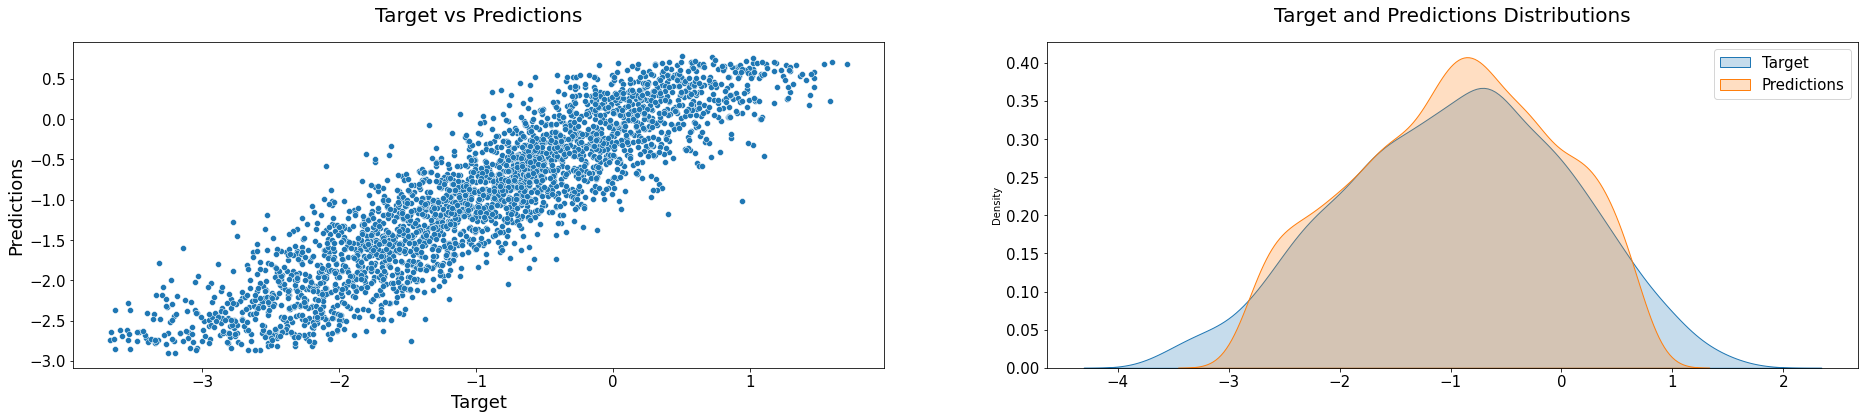

In [45]:
readability_features_scale = 10
use_features_scale = 3

X_train = np.hstack([
    df_train[prediction_columns].values,
    df_train[readability_features].values / readability_features_scale,
    train_use_features / use_features_scale,
])
y_train = df_train['target'].values

X_test = np.hstack([
    df_test[prediction_columns].values,
    df_test[readability_features].values / readability_features_scale,
    test_use_features / use_features_scale,
])

linear_model_svm = LinearModel(
    model_name='svm',
    model_parameters={
        'C': 0.3,
        'kernel': 'rbf'
    }
)

linear_model_svm.train_and_predict_svm(X_train, y_train, X_test)
del X_train, y_train, X_test, linear_model_svm

## Blending

In [46]:
ridge_weight = 0.5
svm_weight = 0.5
df_train['final_predictions'] = (df_train['ridge_predictions'] * ridge_weight) + (df_train['svm_predictions'] * svm_weight)
df_test['final_predictions'] = (df_test['ridge_predictions'] * ridge_weight) + (df_test['svm_predictions'] * svm_weight)

for prediction_column in prediction_columns + ['ridge_predictions', 'svm_predictions', 'final_predictions']:
    oof_score = mean_squared_error(df_train['target'], df_train[prediction_column], squared=False)
    print(f'{prediction_column} - OOF RMSE: {oof_score:.6}')

roberta_base1_predictions - OOF RMSE: 0.48215
roberta_base2_predictions - OOF RMSE: 0.493778
roberta_base3_predictions - OOF RMSE: 0.49036
roberta_base4_predictions - OOF RMSE: 0.492061
maunish_roberta_base1_predictions - OOF RMSE: 0.494809
rhtsingh_roberta_base1_predictions - OOF RMSE: 0.481018
rhtsingh_roberta_large1_predictions - OOF RMSE: 0.479459
rhtsingh_roberta_large2_predictions - OOF RMSE: 0.482326
andretugan_roberta_base1_predictions - OOF RMSE: 0.483203
andretugan_roberta_base2_predictions - OOF RMSE: 0.479711
ridge_predictions - OOF RMSE: 0.458136
svm_predictions - OOF RMSE: 0.458
final_predictions - OOF RMSE: 0.457155


## Submission

In [47]:
df_test['target'] = df_test['final_predictions'].values
df_test[['id', 'target']].to_csv('submission.csv', index=False)
df_test[['id', 'target']].describe()

,target
count,7.000000
mean,-0.949125
std,0.935136
min,-2.415040
25%,-1.553391
50%,-0.536600
75%,-0.413332
max,0.241211
